<a href="https://colab.research.google.com/github/AronAhn/Etc/blob/master/netflix_surprise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/laowingkin/netflix-movie-recommendation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD

In [0]:
dfs = [pd.read_csv('/content/drive/My Drive/netflix/combined_data_%s.txt'%i, header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1]) for i in range(1,5)]

In [0]:
for df in dfs:
  df['Rating'] = df['Rating'].astype(float)

In [0]:
def df_preprocessor(df):
  df_nan = pd.DataFrame(pd.isnull(df.Rating))
  df_nan = df_nan[df_nan['Rating'] == True]
  df_nan = df_nan.reset_index()

  movie_np = []
  movie_id = 1

  for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
      # numpy approach
      temp = np.full((1,i-j-1), movie_id)
      movie_np = np.append(movie_np, temp)
      movie_id += 1

  # Account for last record and corresponding length
  # numpy approach
  last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
  movie_np = np.append(movie_np, last_record)


  df = df[df['Rating'].notnull()]

  df['Movie_Id'] = movie_np.astype(int)
  df['Cust_Id'] = df['Cust_Id'].astype(int)

  return df

dfs = [df_preprocessor(df) for df in dfs]

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [0]:
import gc
print(gc.collect())

df = pd.concat(dfs)
del dfs
print(gc.collect())

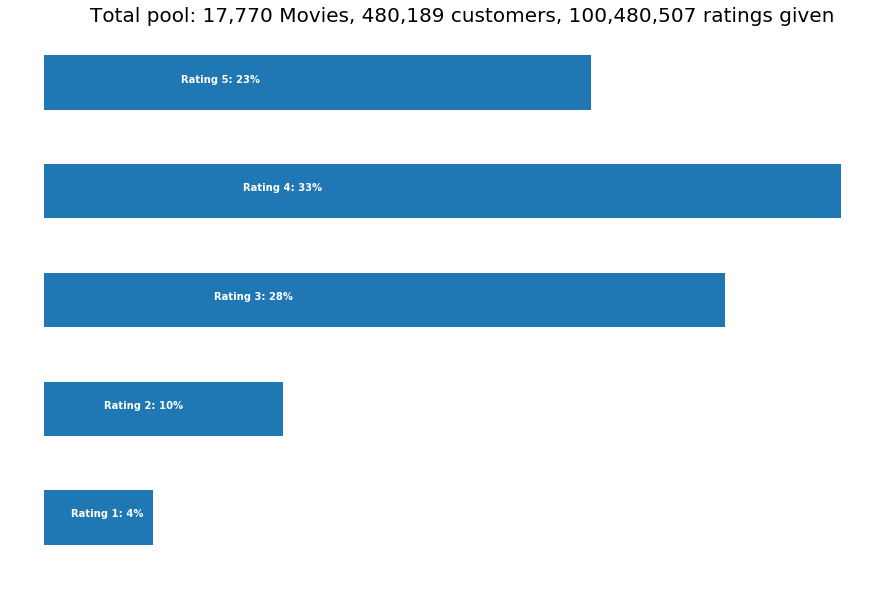

In [5]:
p = df.groupby('Rating')['Rating'].agg(['count'])

# get movie count
movie_count = df.isnull().sum()[1]

# get customer count
cust_count = df['Cust_Id'].nunique() - movie_count

# get rating count
rating_count = df['Cust_Id'].count() - movie_count

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

# plt.hist(df_cust_summary['mean'], bins=30, alpha=0.5, label='cust', density=True)
# plt.hist(df_movie_summary['mean'], bins=30, alpha=0.5, label='movie', density=True)
# plt.legend(loc='upper right')
# plt.show()

ValueError: ignored

In [9]:
# before
print("The density of matrix: %.2f%%"%((len(df) * 100.0) / (df.Cust_Id.nunique() * df.Movie_Id.nunique())))

AttributeError: ignored

In [52]:
f = ['count','mean']

df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Movie minimum times of review: 1799.0
Customer minimum times of review: 52.0


In [70]:
print('Original Shape: {}'.format(df.shape))
df = df[~df['Movie_Id'].isin(drop_movie_list)]
df = df[~df['Cust_Id'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df.shape))
print('-Data Examples-')
print(df.iloc[::5000000, :])

Original Shape: (24053764, 3)
After Trim Shape: (17337458, 3)
-Data Examples-
          Cust_Id  Rating  Movie_Id
696        712664     5.0         3
6932490   1299309     5.0      1384
13860273   400155     3.0      2660
20766530   466962     4.0      3923


In [71]:
print("The density of matrix: %.2f%%"%((len(df) * 100.0) / (df.Cust_Id.nunique() * df.Movie_Id.nunique())))

The density of matrix: 8.95%


In [73]:
df_p = pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')

print(df_p.shape)

(143458, 1350)


In [78]:
from surprise.model_selection import cross_validate

data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']][:100000], reader)

algo = SVD()
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     0.7912  0.8006  0.8035  0.7928  0.7970  0.7970  0.0046  
RMSE (testset)    0.9889  0.9996  1.0040  0.9948  0.9970  0.9969  0.0050  
Fit time          4.25    4.21    4.29    4.26    4.34    4.27    0.04    
Test time         0.16    0.14    0.14    0.14    0.14    0.15    0.01    


{u'fit_time': (4.24741792678833,
  4.211807012557983,
  4.293338060379028,
  4.256542921066284,
  4.342235088348389),
 u'test_mae': array([0.79122292, 0.80060993, 0.80350657, 0.79281474, 0.79699717]),
 u'test_rmse': array([0.98889164, 0.99959707, 1.00402614, 0.99480221, 0.99695708]),
 u'test_time': (0.1575620174407959,
  0.14392900466918945,
  0.14276409149169922,
  0.14318084716796875,
  0.14216399192810059)}

In [79]:
from surprise import accuracy
from surprise.model_selection import train_test_split

trainset, testset = train_test_split(data, test_size=.25)

# We'll use the famous SVD algorithm.
algo = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 0.9995


0.9995114418019645

In [0]:
from surprise import SVD, SVDpp, NMF


In [0]:
def eval_algo(algo):

  # Train the algorithm on the trainset, and predict ratings for the testset
  algo.fit(trainset)
  predictions = algo.test(testset)

  # Then compute RMSE
  pred_df = pd.DataFrame([(pred.r_ui, pred.est) for pred in predictions])
  print(pred_df.corr().loc[0][1])

In [114]:
algo_list = [SVD(), SVDpp(), NMF()]
[eval_algo(algo) for algo in algo_list]

0.2940528351916002
0.23793868660232326
0.14438168921964975


[None, None, None]